<a href="https://colab.research.google.com/github/tuphr2234/ChaosPrediction/blob/main/Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Testing**

## Build Simulation

In [ ]:
#pip install anvil-uplink

In [ ]:
#import anvil.server
#anvil.server.connect("TZUCDKSZYSBTNKHSPELDSW6R-FXNZELV7D3LNEDCN") ## M2SHTQKH2FUIJQQXXX4VKXEB-I37SIP4DTE6Z5NM3

In [ ]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import tensorflow as tf
from pathlib import Path  


G=1


class Body:
  
  prevPosition=np.array([0,0])
  position=np.array([0,0])
  velocity=np.array([0,0])
  force=np.array([0,0])
  acceleration=np.array([0,0])
  mass=0

  def __init__(self,position=[0,0],velocity=[0,0],mass=1,name="newBody"):
    self.position=np.array(position)
    self.velocity=np.array(velocity)
    #self.acceleration=np.array(acceleration)
    self.mass=mass
    self.prevPosition=np.array(position)
    self.name = name


  def setInitialPostion(self,position):
    self.postion = np.array(position)
    self.prevPosition=np.array(position)

    
  def setInitialVelocity(self,velocity):
    self.velocity = np.array(velocity)

   
  def setInitialMass(self,mass):
    self.mass = mass




  def setPosition(self,t):
    self.prevPosition = self.position
    self.position=self.position+self.velocity*t+(self.acceleration/2)* t**2
  

  def setVelocity(self,t):
    self.velocity=self.velocity+self.acceleration*t
  

  def getForce(self,body):
    softening = 0.01
    Distance = body.prevPosition - self.position
    Rsquare = Distance[0]**2 + Distance[1]**2 + softening
    #F = G* self.mass*body.mass / Rsquare  
    F = (G* self.mass*body.mass / Rsquare) #- 0.001 / (Rsquare * Rsquare) ### Lennard-Jones like force
    normalizeDis = Distance / math.sqrt(Rsquare)
    F = F*normalizeDis
    if math.sqrt(Rsquare) < softening:
      F = -F 
    
    return F

  def setAcceleration(self,bodies):
    F=np.array([0,0])
    for body in bodies:
      F=F+self.getForce(body)
    self.acceleration = F/self.mass
   # print(f" {self.name} acceleration is {self.acceleration}")

In [ ]:
def centerOfMass(vect):
  out =np.array([0,0])
  for i in range(0,len(vect),2):
    out = out + np.array(vect[i],vect[i+1])
  return out / (len(vect)//2) 

In [ ]:
def subtractCenterOfMass(simulation):
  for i in range(len(simulation)):
    add = np.zeros(len(simulation[0]))
    for j in range(0,len(add),2):
       add[j] =centerOfMass(simulation[i])[0]
       add[j+1] =centerOfMass(simulation[i])[1] 
    simulation[i] = simulation[i] - add

In [ ]:
def addCenterOfMass(simulation):
  for i in range(len(simulation)):
    add = np.zeros(len(simulation[0]))
    for j in range(0,len(add),2):
       add[j] =centerOfMass(simulation[i])[0]
       add[j+1] =centerOfMass(simulation[i])[1] 
    simulation[i] = simulation[i] + add

In [ ]:

def simulateOnTimeStep(bodies,t,steps,interval_in_data): # bodies: list of bodies. t: timestep . steps: number of steps. interval_in_data : frequency of rows taken to dataset: if equals 1 than it is every step
  dataset = []

  for i in range(steps):
      list1=[]
      for body in bodies:
        list1.append(body.position)
      if i % interval_in_data ==0:
        dataset += list1
      
      for i,body in enumerate(bodies):
        body.setAcceleration([b for b in bodies if b is not body])
        body.setVelocity(t)
        body.setPosition(t)
       
        
      for body in bodies:
        body.prevPosition = body.position
    

  return np.array(dataset).reshape(steps//interval_in_data,len(bodies),2)



In [ ]:
def numpyToPandas(simulation,numOfBodies):
  columns = []

  for i in range(numOfBodies):
    columns.append(f'Body{i+1} x')
    columns.append(f'Body{i+1} y')
  simulation_reshaped = simulation.reshape(len(simulation), numOfBodies*2 )

  df = pd.DataFrame(simulation_reshaped, columns = columns)
  return df


## Add Filters

In [ ]:
def addNoise(simulation):
  noise = np.random.normal(0, .1, simulation.shape)
  return simulation + noise
def removeBody(simulation, bodyNum):
  del1 = np.delete(simulation,(bodyNum-1)*2,1)
  return np.delete(del1,(bodyNum-1)*2,1)

## Save Simulation

In [ ]:
## save simulation as csv
def saveSimulation(simulation,numOfBodies,simulation_name):
  df = numpyToPandas(simulation,numOfBodies) 
  df.to_csv(f'/content/{simulation_name}.csv',index=False)
  
def loadSimulation(df):
  global runTime_simulation
  runTime_simulation = pd.DataFrame.to_numpy(df)
  return runTime_simulation

## Prepare Dataset 

In [ ]:
def prepareData(simulation,window_size_X,window_size_y): 
  X = []
  y = []
  for i in range(len(simulation)-window_size_X - window_size_y):
    row = [bodies for bodies in simulation[i:i+window_size_X]]  
    X.append(row)
    label =  [bodies for bodies in simulation[i+window_size_X:i+window_size_X + window_size_y]]#######################################
    y.append(label)

  return np.array(X) , np.array(y)


In [ ]:
def splitToTrainValidTest(dataset,testPercentage=0.1):
  trainLen = round((len(dataset)*(1-testPercentage-0.1)))
  valLen = round((len(dataset)*0.1))
  train_set = dataset[:trainLen]
  val_set = dataset[trainLen:trainLen+valLen]
  test_set = dataset[trainLen+valLen:]
  return train_set,val_set,test_set

## Draw

In [ ]:
def drawSimulation(simulation):
  prev = np.copy(simulation[0])
  numOfBodies = len(simulation[0])
  from random import randint
  colors = []

 # for i in range(30):
   # colors.append('#%06X' % i *  randint(0, 0xFFFFFF)) ## 

  colors = ['red','green','blue','yellow','black','brown','purple','pink','orange','turquoise']
  for i,sim in enumerate(simulation):
    #if i == 0:
      #continue
    for j in range(0,len(sim),2):
      plt.plot([prev[j],sim[j]],[prev[j+1],sim[j+1]],  color = colors[j // 2])
      prev[j] = np.copy(sim[j])
      prev[j+1] = np.copy(sim[j+1])
  plt.show()


In [ ]:
def showBodiesMovmentInGraph(simulation):
  plt.title("X body coordinate")
  for i in range(0,len(simulation.columns),2):
      df = simulation.iloc[:,i]
      plt.plot(df)
  plt.show()
  plt.title("Y body coordinate")
  for i in range(1,len(simulation.columns),2):
      df = simulation.iloc[:,i]
      plt.plot(df)
  plt.show()

## Models

### Sliding window

In [ ]:
# Model Prediction with "sliding window" method
def slidingWindowActualPredictions(model,windowArr,windowSize,NumOfBodies,predictionsRequestedNumber): ### One step at a time autoregression
  actualPredictionArr =[]
  for i in range(predictionsRequestedNumber):

    prediction = model.predict(windowArr[-1:]) ### predict from last window
    actualPredictionArr.append(prediction)
    temp = np.zeros([windowSize,numOfBodies*2])
    temp = temp + windowArr[-1]
    temp =temp[1:]
    newWindow = np.append(temp.reshape(windowSize-1,numOfBodies*2),prediction)
    newWindow = newWindow.reshape(windowSize,numOfBodies*2)
    lengthX = len(windowArr)
    windowArr = np.append(windowArr,newWindow) ### add new window that the last vector is the prediction 
    windowArr = windowArr.reshape(lengthX+1,windowSize,numOfBodies*2)

  return actualPredictionArr

### Post process

In [ ]:
def postprocess(lastKnownElement , listOfPredictedChanges):
  listOfPredictions = []
  for pred in listOfPredictedChanges:
    #newElement = (pred * np.linalg.norm(lastKnownElement)) + lastKnownElement
    newElement = pred + lastKnownElement
    listOfPredictions.append(newElement)
    lastKnownElement = newElement
  return np.array(listOfPredictions)


### CNN model

In [ ]:
## CNN blocks

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

def buildModelCNN(window_size_X,window_size_y,numberOfBodies): 
  model = Sequential()
  model.add(tf.keras.layers.Conv2D(32, (3,3), padding="same", activation="relu", input_shape=(window_size_X, numberOfBodies*2, 1)))
  model.add(tf.keras.layers.Conv2D(32, (5,5), padding="same", activation="relu", input_shape=(window_size_y, numberOfBodies*2, 1)))
  model.add(Flatten())
  model.add(Dense(units =  window_size_y*numberOfBodies*2, activation ='linear'))
  model.add(tf.keras.layers.Reshape([window_size_y, numberOfBodies*2]))
  model.summary()
  return model
  

In [ ]:
#@title
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

def buildModelCNN(window_size_X,window_size_y,numberOfBodies): 
    model = Sequential()
    model.add(InputLayer((window_size_X,numberOfBodies*2,1)))


    model.add(tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"))
    model.add(tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"))
    model.add(tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"))
    model.add(tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())

    model.add(Dense(units =  window_size_y*numberOfBodies*2, activation ='linear'))
    model.add(tf.keras.layers.Reshape([window_size_y, numberOfBodies*2]))

    model.summary()

    return model

In [ ]:
def hidden_state_cnn(window_size_X,window_size_y,numberOfBodies,hidden_state):
    
    inp = InputLayer((window_size_X,numberOfBodies*2,1))

    
    x = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu")(inp)
    x = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.2)(x)
    x = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.2)(x)
    x = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = (tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = Flatten()(x)

    x = Dense(units =  window_size_y*numberOfBodies*2, activation ='linear')(x)
    output = tf.keras.layers.Reshape([window_size_y, numberOfBodies*2])(x)
    
    model = Model(inputs=inp, outputs=output)

    model.summary()

    return model , hidden_state








### DenseNet

In [ ]:
#@title
def DenseNet(window_size_X,window_size_y,numberOfBodies):

    inputs = Input(shape=(window_size_X, numberOfBodies*2, 1))

    # first dense block
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = Concatenate()([inputs, x])

    # second dense block
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Concatenate()([inputs, x])

    # third dense block
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = Concatenate()([inputs, x])

    # output layer
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = Flatten()(x)

    x = Dense(window_size_y * numberOfBodies*2, activation='linear')(x)
    output = (tf.keras.layers.Reshape([window_size_y, numberOfBodies*2]))(x)
    model = Model(inputs=inputs, outputs=output)
    model.summary()
    return model


### ResNet

In [ ]:
#@title
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *

class ResNetBlock(Layer):

  def __init__(self, out_channels, first_stride=1):
    super().__init__()

    first_padding = 'same'
   # if first_stride != 1:
      #first_padding = 'valid'

    self.conv_sequence = Sequential([
                            Conv2D(out_channels, 3, 
                                   first_stride, padding=first_padding),
                            BatchNormalization(),
                            ReLU(),

                            Conv2D(out_channels, 3, 
                                   1, padding='same'),
                            BatchNormalization(),
                            ReLU()
    ])

  def call(self, inputs):
    x = self.conv_sequence(inputs)
    
    if x.shape == inputs.shape:
      x = x + inputs
    return x

#layer = ResNetBlock(4)
#print(layer)

In [ ]:
#@title
class ResNet(Model):
  def __init__(self,window_size_X,window_size_y,numberOfBodies):
    super(ResNet, self).__init__()
    
    self.conv_1 = Sequential([Conv2D(64, 7, 2,input_shape=(window_size_X, numberOfBodies*2, 1)),
                              ReLU(),
                              MaxPooling2D(3, 2)
                  ])
    
    self.resnet_chains = Sequential([ResNetBlock(64), ResNetBlock(64)] +
                                    [ResNetBlock(128, 2), ResNetBlock(128)] +
                                    [ResNetBlock(256, 2), ResNetBlock(256)] +
                                    [ResNetBlock(512, 2), ResNetBlock(512)])
  
    self.out = Sequential([GlobalAveragePooling2D(),
                           Dense(window_size_y*numberOfBodies*2, activation='linear'),
                           Reshape([window_size_y, numberOfBodies*2])
    ])
    
  def call(self, x):
    x = self.conv_1(x)
    x = self.resnet_chains(x)
    x = self.out(x)
    return x

#print(model)

### LSTM

In [ ]:
#@title
def buildModelLSTM(window_size_X,window_size_y,numberOfBodies): 
 # model.add(InputLayer((window_size_X,numberOfBodies*2)))

  model = keras.Sequential()
  model.add(keras.layers.LSTM(128, kernel_initializer='he_uniform', batch_input_shape=(None, window_size_X, numberOfBodies*2), return_sequences=True, name='encoder_1'))
  model.add(keras.layers.LSTM(64, kernel_initializer='he_uniform', return_sequences=True, name='encoder_2'))
  model.add(keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='encoder_3'))
  model.add(keras.layers.Flatten())

  model.add(tf.keras.layers.Dense(units =  window_size_y*numberOfBodies*2, activation ='linear'))
  model.add(tf.keras.layers.Reshape([window_size_y, numberOfBodies*2]))
  model.summary()
  return model

### Wavelet

In [ ]:
#@title
!pip install tensorflow-wavelets


In [ ]:
#@title
import tensorflow_wavelets.Layers.DWT as DWT
import tensorflow_wavelets.Layers.DTCWT as DTCWT
import tensorflow_wavelets.Layers.DMWT as DMWT
import tensorflow_wavelets.Layers.Threshold as Threshold


def waveletModel(window_size_X,window_size_y,numberOfBodies,waveletName = 'haar'): # pywt.wavelist(family)  https://www.kaggle.com/code/theoviel/denoising-with-direct-wavelet-transform 
    model = keras.Sequential()
    model.add(keras.Input(shape=(window_size_X,numberOfBodies*2, 1)))  # model.add(keras.Input(shape=(window_size_X,numberOfBodies*2, 1)))
    model.add(DWT.DWT(name=waveletName,concat=0)) # cmor \ coif10 \ db4 \ db38 
    model.add(Conv2D(32, kernel_size=(3,3)))
    model.add(keras.layers.Flatten())
    

    model.add(keras.layers.Dense(units =  window_size_y*numberOfBodies*2, activation ='linear'))
    model.add(tf.keras.layers.Reshape([window_size_y, numberOfBodies*2]))
    model.summary()
    return model

In [ ]:
#@title
'''
from tensorflow.keras import layers
def wavelet(window_size_X,window_size_y,numberOfBodies,waveletName = 'ghm'):
    x_inp = layers.Input(shape=(window_size_X,numberOfBodies*2, 1))
    x = DMWT(waveletName)(x_inp)
    x = Threshold.Threshold(algo='sure', mode='hard')(x) # use "soft" or "hard"
    x = IDMWT(waveletName)(x)
    model = Model(x_inp, x, name="MyModel")
    model.summary()
    return model
    '''

'\nfrom tensorflow.keras import layers\ndef wavelet(window_size_X,window_size_y,numberOfBodies,waveletName = \'ghm\'):\n    x_inp = layers.Input(shape=(window_size_X,numberOfBodies*2, 1))\n    x = DMWT(waveletName)(x_inp)\n    x = Threshold.Threshold(algo=\'sure\', mode=\'hard\')(x) # use "soft" or "hard"\n    x = IDMWT(waveletName)(x)\n    model = Model(x_inp, x, name="MyModel")\n    model.summary()\n    return model\n    '

### U_Net

In [ ]:
#@title

def U_Net(window_size_X,window_size_y,numberOfBodies):

    inputs = tf.keras.layers.Input((window_size_X,  numberOfBodies*2))

    c1 = tf.keras.layers.Conv1D(16, 3, activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling1D(2)(c1)

    c2 = tf.keras.layers.Conv1D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv1D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling1D(2)(c2)

    c3 = tf.keras.layers.Conv1D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv1D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling1D(2)(c3)

    c4 = tf.keras.layers.Conv1D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv1D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling1D(pool_size=2)(c4)

    c5 = tf.keras.layers.Conv1D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv1D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = tf.keras.layers.Conv1DTranspose(128, 3, strides=1, padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv1D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv1D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv1DTranspose(64, 3, strides=1, padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv1D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv1D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv1DTranspose(32, 2, strides=1, padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv1D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv1D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv1DTranspose(16, 2, strides=1, padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    c9 = tf.keras.layers.Conv1D(16, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv1D(16, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    c9 = Flatten()(c9)

    output = Dense(window_size_y * numberOfBodies*2, activation='linear')(c9)
    output = (tf.keras.layers.Reshape([window_size_y, numberOfBodies*2]))(output)   

    model = tf.keras.Model(inputs=[inputs], outputs=output)
    model.summary()
    return model    

### Inception

In [ ]:
#@title
### Inception


from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

def inception_module(x, base_channels=32):
  #a = Conv2D(base_channels*2, 1, 1, activation='relu')(x)
  
  
  b_1 = Conv2D(base_channels*2, 3, 1, activation='relu')(x)
  b_2 = Conv2D(base_channels*4, 3, 1, padding='same', activation='relu')(b_1)
  #b_2 =BatchNormalization()(b_2)

  c_1 = Conv2D(base_channels, 3, 1, activation='relu')(x)
  c_2 = Conv2D(base_channels, 5, 1, padding='same', activation='relu')(c_1)
  #c_2 =BatchNormalization()(c_2)


  #d_1 = MaxPooling2D(3, 1, padding='same')(x)
  d_1 = Conv2D(base_channels, 3, 1, activation='relu')(x)
  d_2 = Conv2D(base_channels, 5, 1, padding='same', activation='relu')(d_1)




  return Concatenate(axis=-1)([b_2, c_2, d_2])

def Inceptionmodel(window_size_X,window_size_y,numberOfBodies):

  inp = Input((window_size_X, numberOfBodies*2, 1))

  maps_1 = inception_module(inp)
  maps_2 = inception_module(maps_1, base_channels=16)
  #maps_3 = inception_module(maps_2, base_channels=32)
  #maps_4 = inception_module(maps_3, base_channels=16)
  #gap = GlobalMaxPooling2D()(maps_4)
  flatten = Flatten()(maps_2)

  output = Dense(window_size_y * numberOfBodies*2, activation='linear')(flatten)
  output = (tf.keras.layers.Reshape([window_size_y, numberOfBodies*2]))(output)
  model = Model(inputs=inp, outputs=output)
  model.summary()
  return model
  
  

In [ ]:
#Inceptionmodel(100,100,3)

### Inception model Wavelet

In [ ]:
#@title
### Inception


from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

def inception_module_wavelet(x, base_channels=32):
  #a = Conv2D(base_channels*2, 1, 1, activation='relu')(x)
  
  b_0 = DWT.DWT(name='haar',concat=0)(x)
  b_1 = Conv2D(base_channels*2, 3, 1, activation='relu')(b_0)
  b_2 = Conv2D(base_channels*4, 3, 1, padding='same', activation='relu')(b_1)

  #b_2 =BatchNormalization()(b_2)
  
  c_0 = DWT.DWT(name='haar',concat=0)(x)
  c_1 = Conv2D(base_channels, 3, 1, activation='relu')(c_0)
  c_2 = Conv2D(base_channels, 5, 1, padding='same', activation='relu')(c_1)
  #c_2 =BatchNormalization()(c_2)


  d_1 = DWT.DWT(name='coif10',concat=0)(x) 
  d_2 = Conv2D(base_channels, 1, 1, activation='relu')(d_1)




  return Concatenate(axis=-1)([b_2, c_2])

def InceptionmodelWavelet(window_size_X,window_size_y,numberOfBodies):

  inp = Input((window_size_X, numberOfBodies*2, 1))

  maps_1 = inception_module_wavelet(inp)
  maps_2 = inception_module_wavelet(maps_1, base_channels=32)
  
  #gap = GlobalMaxPooling2D()(maps_2)
  flatten = Flatten()(maps_2)

  output = Dense(window_size_y * numberOfBodies*2, activation='linear')(flatten)
  output = (tf.keras.layers.Reshape([window_size_y, numberOfBodies*2]))(output)
  model = Model(inputs=inp, outputs=output)
  model.summary()
  return model


### Autoencoder

In [ ]:
#@title
# add reduction factor
class Autoencoder(Model):

  def __init__(self,window_size_X =100, numberOfBodies =3,reduction_factor = 20):
   
    super(Autoencoder, self).__init__()
    self.encoder = tf.keras.Sequential([
    layers.Input(shape=(window_size_X, numberOfBodies*2, 1)),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
    layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2),
    layers.Flatten(),
    layers.Dense((window_size_X//reduction_factor)*numberOfBodies*2, activation='relu'),
    layers.Reshape([window_size_X//reduction_factor, numberOfBodies*2,1])  
    ])

    self.decoder = tf.keras.Sequential([
    layers.Input(shape=((window_size_X//reduction_factor),numberOfBodies*2,1)),
    layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
    layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
    layers.Conv2D(1, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.Flatten(),
    layers.Dense(units = window_size_X* numberOfBodies*2, activation='linear'),
    layers.Reshape([window_size_X, numberOfBodies*2])


    ])
 


  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

  


### CNN LSTM

In [ ]:
#@title
def cnnLstm(window_size_X,window_size_y,numberOfBodies):
    x = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", input_shape=(window_size_X, numberOfBodies*2, 1))
    x = tf.keras.layers.TimeDistributed(x)
    x = Flatten()(x)
    x = LSTM(64)(x)
    return x


### Transformer encoder

In [ ]:
#@title
## Transformer

from tensorflow import keras
from tensorflow.keras import layers

##  PE(pos, 2i) = sin(pos / 10000^(2i/d))

##  PE(pos, 2i+1) = cos(pos / 10000^(2i/d))

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.Dense(units =36*100 , activation='linear')(inputs)
    
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
  #  x = layers.LayerNormalization(epsilon=1e-6)(res)
  #  x = layers.Conv2D(filters=ff_dim, kernel_size=1, activation="relu")(x)
  #  x = layers.Dropout(dropout)(x)
  #  x = layers.Conv2D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x 


def transformerModel(
    window_size_X=100,
    head_size=128,
    num_heads=6,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    dropout=0.0,
    mlp_dropout=0.25,
    window_size_y=100,
    numberOfBodies=3
):
    inputs = keras.Input(shape=(window_size_X, numberOfBodies*2, 1))
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    
    x = Flatten()(x)

   # x = layers.GlobalAveragePooling2D(data_format="channels_first")(x)

    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(units =  window_size_y*numberOfBodies*2, activation ='linear')(x)
    outputs = (tf.keras.layers.Reshape([window_size_y, numberOfBodies*2]))(outputs)

    return keras.Model(inputs, outputs)  
    

In [ ]:
## Transformer

from tensorflow import keras
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


def build_model(
    window_size_X=100,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    dropout=0.4,
    mlp_dropout=0.25,
    window_size_y=100,
    numberOfBodies=3
):
    inputs = keras.Input(shape=(window_size_X, numberOfBodies*2, 1))
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling2D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(units =  window_size_y*numberOfBodies*2, activation ='linear')(x)
    outputs = (tf.keras.layers.Reshape([window_size_y, numberOfBodies*2]))(outputs)

    return keras.Model(inputs, outputs)  
    

In [ ]:
## Transformer

from tensorflow import keras
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv2D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv2D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


def transformerModel(
    window_size_X=100,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    dropout=0.4,
    mlp_dropout=0.25,
    window_size_y=100,
    numberOfBodies=3
):
    inputs = keras.Input(shape=(window_size_X, numberOfBodies*2, 1))
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    
    x = Flatten()(x)

   # x = layers.GlobalAveragePooling2D(data_format="channels_first")(x)

    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(units =  window_size_y*numberOfBodies*2, activation ='linear')(x)
    outputs = (tf.keras.layers.Reshape([window_size_y, numberOfBodies*2]))(outputs)

    return keras.Model(inputs, outputs)  
    

In [ ]:
transformerModel()


## Prediction functions

In [ ]:

def autoRegressivePrediction(model,window,predictionLength,slideSize =1,numOfBodies = 3):
  predictions = []
  for i in range(predictionLength):
    pred = model.predict(window)
    predictions.append(pred.squeeze().squeeze())
    window = np.concatenate((window,pred),axis = 1)
    print(window.shape)

    window = window[:,slideSize:,:]
    print(window.shape)
    print("fsdf")
  return predictions

In [ ]:
#InceptionmodelWavelet(100,100,3)

In [ ]:
def predict(model,X_window,initialVector):
  predictions = model.predict(X_window)
  predictions = predictions.squeeze()
  return postprocess(initialVector,predictions)

In [ ]:
def draw_real_vs_prediction(real,simulated,i=0,j=100):
  plt.title(f"Real Trajectory in range {i}-{j}")
  drawSimulation(real[i:j])
  plt.title(f"Predicted Trajectory in range {i}-{j}")
  drawSimulation(simulated[i:j])


In [ ]:
def preprocessSimulation(simulation):
  shape = simulation[0].shape
  newSimulation = np.append(simulation[1:],[np.zeros(shape)],axis=0) - simulation
  newSimulation = newSimulation[:-1]
  for i,s in enumerate(newSimulation):
    s = s / np.linalg.norm(simulation[i])
  return newSimulation

In [ ]:
def postprocess(lastKnownElement , listOfPredictedChanges):
  listOfPredictions = []
  listOfPredictedChanges = listOfPredictedChanges.squeeze()
  for pred in listOfPredictedChanges:
    #newElement = (pred * np.linalg.norm(lastKnownElement)) + lastKnownElement
    newElement = pred  + lastKnownElement
    listOfPredictions.append(newElement)
    lastKnownElement = newElement
  return np.array(listOfPredictions)  


In [ ]:
def rand(x):
  return np.random.uniform(-x,x)


In [ ]:
def createRandomSimulation(numOfBodies,timestep,steps,interval_in_data):
  bodies =[]
  for i in range(numOfBodies):
    bodies.append( Body( np.array([rand(),rand()]), np.array([rand() , rand()]) , 1 ) )

  simulation = simulateOnTimeStep(bodies,timestep,steps,interval_in_data)
  simulation=simulation.reshape(len(simulation), numOfBodies*2 )
  return simulation


## Three Body Simulation test

### Run a simulation

In [ ]:
## generate random simulations

 N = 20



for i in range(1,N):
    bodies=[]
    


    bodies.append(Body([-0.97000436+rand(0.3), 0.24308753+rand(0.3)],[0.4662036850+rand(0.3), 0.4323657300+rand(0.3)],1,"body1"))
    bodies.append(Body([0.97000436+rand(0.3), -0.24308753+rand(0.3)],[0.4662036850+rand(0.3), 0.4323657300+rand(0.3)],1,"body2"))
    bodies.append(Body([0+rand(0.3), 0+rand(0.3)],[-0.93240737+rand(0.3), -0.86473146+rand(0.3)],1,"body3"))



    #bodies.append(Body([rand(),rand()],[rand(),rand()],1,"body1"))
    #bodies.append(Body([rand(),rand()],[rand(),rand()],1,"body2"))
    #bodies.append(Body([rand(), rand()],[rand(),rand()],1,"body3"))
    

    ##########################################

    # The 8 Figure motion initials

    #bodies.append(Body([-0.97000436, 0.24308753],[0.4662036850, 0.4323657300],1,"body1"))
    #bodies.append(Body([0.97000436, -0.24308753],[0.4662036850, 0.4323657300],1,"body2"))
    #bodies.append(Body([0, 0],[-0.93240737, -0.86473146],1,"body3"))

    ##########################################

    numOfBodies=len(bodies)
    ##t: timestep . steps: number of steps. interval_in_data
    timestep = 0.00005 # actual seconds
    steps = 2220000
    #steps = 3000000
    interval_in_data = 500

    simulation = simulateOnTimeStep(bodies,timestep,steps,interval_in_data)
    simulation=simulation.reshape(len(simulation), numOfBodies*2 )
    saveSimulation(simulation,numOfBodies,f"{numOfBodies}-Body Simulation{i}")




In [ ]:
bodies=[]

bodies.append(Body([-0.91000436, 0.24308753],[0.5662036850, 0.4323657300],1,"body1"))
bodies.append(Body([0.97000436, -0.24308753],[0.3662036850, 0.4323657300],1,"body2"))
bodies.append(Body([0, 0],[-0.73240737, -0.76473146],1,"body3"))

numOfBodies=len(bodies)
##t: timestep . steps: number of steps. interval_in_data
timestep = 0.00005 # actual seconds
steps = 2220000
#steps = 3000000
interval_in_data = 500

simulation1 = simulateOnTimeStep(bodies,timestep,steps,interval_in_data)


In [ ]:
simulation1=simulation1.reshape(len(simulation1), numOfBodies*2 )


In [ ]:
drawSimulation(simulation1)
saveSimulation(simulation1,numOfBodies,f"{numOfBodies}-Body Simulation")


### Load simulation from a csv file

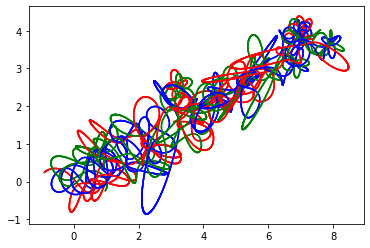

In [ ]:


## When loading


simulation1 = loadSimulation(pd.read_csv(f'/content/3-Body Simulation.csv'))
numOfBodies = simulation1.shape[1] // 2

drawSimulation(simulation1)


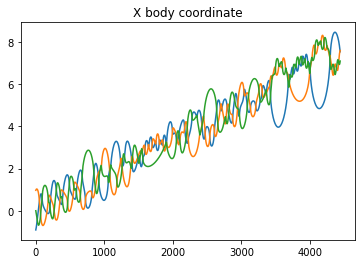

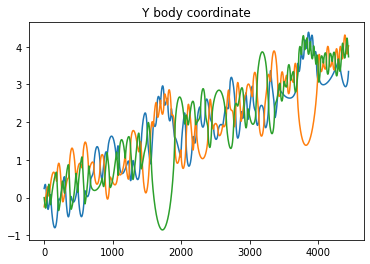

In [ ]:
showBodiesMovmentInGraph(numpyToPandas(simulation1,numOfBodies))


In [ ]:
'''
simulations = []
for i in range(1,18):
  simulations.append(loadSimulation(pd.read_csv(f'/content/3-Body Simulation{i}.csv')))

#simulation2 = loadSimulation(pd.read_csv(f'/content/4-Body Simulation1.csv'))
#simulation3 = loadSimulation(pd.read_csv(f'/content/4-Body Simulation2.csv'))
#simulation4 = loadSimulation(pd.read_csv(f'/content/4-Body Simulation3.csv'))
diff_simulations =[]
for i in range(0,17):
  diff_simulations.append(simulations[i])
 
'''

In [ ]:
#testSimulation = loadSimulation(pd.read_csv(f'/content/3-Body Simulation{19}.csv'))

In [ ]:
'''

import pywt

def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def wavelet_denoising(x, wavelet='db4', level=0):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')

'''


### Prepare data for training generated simulation

In [ ]:
from scipy import stats 
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.signal import hilbert
from scipy.stats import boxcox
scaled = True 

batch = 4

'''
simulation1+=10
for i in range(simulation1.shape[1]):
    simulation1[:,i] = boxcox(simulation1[:,i], lmbda=0)
'''

train, val, test = splitToTrainValidTest(simulation1,0.1)

diff_train = np.diff(train,axis = 0)
diff_val = np.diff(val,axis = 0)
diff_test = np.diff(test,axis = 0)


windowSizeX=100  #len(test)
windowSizeY =100  #len(test)


if scaled:
  scaler = StandardScaler()
  scaler.fit(diff_train)
  #valScaler.fit(train)  ### train / val as input ? 

  train = scaler.transform(train)
  val = scaler.transform(val)



X_train, y_train = prepareData(diff_train,windowSizeX,windowSizeY )
X_val, y_val = prepareData(diff_val,windowSizeX,windowSizeY)
X_test, y_test = prepareData(diff_test,windowSizeX,windowSizeY)



'''
*** when building model based on multiple simulations

simulations_X_train=[]
simulations_y_train =[]

for i in range(17):
  X,y = prepareData(diff_simulations[i],windowSizeX,windowSizeY)
  simulations_X_train.append(X)
  simulations_y_train.append(y)

simulations_X_train =np.array(simulations_X_train)
simulations_y_train =np.array(simulations_y_train)

## X_testSimulation, y_testSimulation = prepareData(testSimulation,windowSizeX,windowSizeY)

mergedX = np.append(simulations_X_train[0],simulations_X_train[1],axis=0)
for i in range(2,17):
  mergedX = np.append(mergedX,simulations_X_train[i],axis=0)

mergedy = np.append(simulations_y_train[0],simulations_y_train[1],axis=0)
for i in range(2,17):
  mergedy = np.append(mergedy,simulations_y_train[i],axis=0)

'''

'\n*** when building model based on multiple simulations\n\nsimulations_X_train=[]\nsimulations_y_train =[]\n\nfor i in range(17):\n  X,y = prepareData(diff_simulations[i],windowSizeX,windowSizeY)\n  simulations_X_train.append(X)\n  simulations_y_train.append(y)\n\nsimulations_X_train =np.array(simulations_X_train)\nsimulations_y_train =np.array(simulations_y_train)\n\n## X_testSimulation, y_testSimulation = prepareData(testSimulation,windowSizeX,windowSizeY)\n\nmergedX = np.append(simulations_X_train[0],simulations_X_train[1],axis=0)\nfor i in range(2,17):\n  mergedX = np.append(mergedX,simulations_X_train[i],axis=0)\n\nmergedy = np.append(simulations_y_train[0],simulations_y_train[1],axis=0)\nfor i in range(2,17):\n  mergedy = np.append(mergedy,simulations_y_train[i],axis=0)\n\n'

In [ ]:
simulation1.shape

(4440, 6)

### Choose model 

In [ ]:
#model =  buildModelCNN(windowSizeX,windowSizeY,numOfBodies)
#model =  buildModelLSTM(windowSizeX,windowSizeY,numOfBodies)
#model = Inceptionmodel(windowSizeX,windowSizeY, numOfBodies)
#model = InceptionmodelWavelet(windowSizeX,windowSizeY, numOfBodies)
#model = wavelet(windowSizeX,windowSizeY, numOfBodies)
model = transformerModel(window_size_X=windowSizeX,window_size_y=windowSizeY,numberOfBodies=numOfBodies)
#model = LSTMmodel(windowSizeX,windowSizeY, numOfBodies)
#model = waveletModel(windowSizeX,windowSizeY, numOfBodies)
#model = DenseNet(windowSizeX,windowSizeY,numOfBodies)
#model = ResNet(windowSizeY,numOfBodies)
#model = U_Net(windowSizeX,windowSizeY,numOfBodies)

cp1 = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss=keras.losses.MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

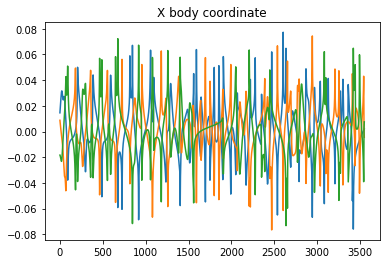

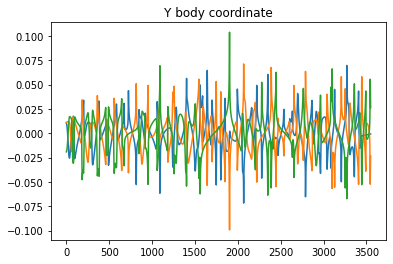

In [ ]:
showBodiesMovmentInGraph(numpyToPandas(diff_train,numOfBodies))

### Train model

In [ ]:
history = model.fit(X_train,y_train, validation_data=(X_val, y_val), epochs=15, callbacks=[cp1],batch_size = 32)

### Custom training

In [ ]:
BATCH_SIZE = 32

X_train_batchs = tf.data.Dataset.from_tensor_slices(X_train)
X_train_batchs = X_train_batchs.batch(BATCH_SIZE)
y_train_batchs = tf.data.Dataset.from_tensor_slices(y_train)
y_train_batchs = y_train_batchs.batch(BATCH_SIZE)




num_epochs = 15


optimizer = keras.optimizers.Adam()
loss_fn = keras.losses.MeanSquaredError()
RMSE = keras.metrics.RootMeanSquaredError()

# Training Loop
for epoch in range(num_epochs):
    print(f"\nStart of Training Epoch {epoch}")
    for i,(X, y) in enumerate(zip(X_train_batchs,y_train_batchs)):
        
        with tf.GradientTape() as tape:
            y_pred = model(X, training=True)
            loss = loss_fn(y, y_pred) * np.exp(i/len(X_train_batchs))  
        
 #       with tf.GradientTape() as tape2:
 #           X_pred_inv = inv_model(y_pred, training=True)
 #           loss_inv =  loss_fn(X,X_pred_inv) 

        gradients = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        
##        gradients_inv = tape2.gradient(loss_inv, inv_model.trainable_weights)
 #       optimizer.apply_gradients(zip(gradients_inv, inv_model.trainable_weights))


        RMSE.update_state(y, y_pred)

    RMSE_value = RMSE.result()
    print(f"RMSE over epoch {RMSE_value}")
    RMSE.reset_states()



In [ ]:

# Test Loop
for  X, y in zip(X_val,y_val):
    X =  np.expand_dims(X, axis=0)
    y = np.expand_dims(y, axis=0)
    y_pred = model(X, training=True)
    RMSE.update_state(y, y_pred)

RMSE_value = RMSE.result()
print(f"RMSE over Test Set: {RMSE_value}")
RMSE.reset_states()    

RMSE over Test Set: 0.0021601812914013863


In [ ]:
plt.plot(history.history['loss']) # 1.7*e^-5
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#history = model.fit_generator(generator,epochs=100,verbose=1)

### Predict

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
#predictions = predict(model,X_val[:1],val[100])
predictions = model.predict(X_val[:1])

#real = postprocess(val[100],y_val[:1])
real = y_val[:1]
real = real.squeeze()
predictions = predictions.squeeze()
print(math.sqrt(mean_squared_error(real,predictions)))

1/1 [==============================] - 0s 82ms/step
0.0030048468303180546


In [ ]:
### Distance at each point throught the prediction
import matplotlib.pyplot as plt
disArr = []
#for i in range(len(val)+len(test)):
  #disArr.append(np.linalg.norm(simulation1[len(X_train)+windowSizeX+i+1]-listOfPredictionsTrue[i]))
for i in range(windowSizeY):
  disArr.append(np.linalg.norm(real[i]-predictions[i]))

plt.plot(disArr)  

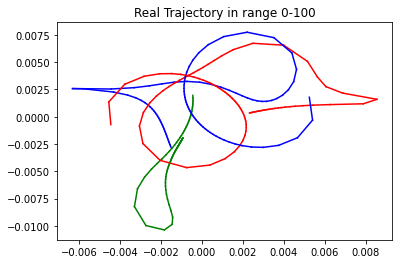

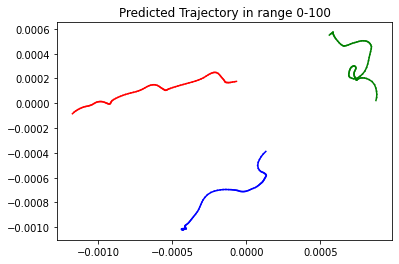

In [ ]:

draw_real_vs_prediction(real, predictions,0,100)

## Double Pendulum test



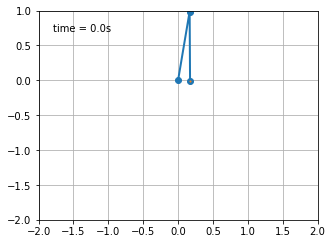

In [ ]:
####
'''
Source: https://matplotlib.org/stable/gallery/animation/double_pendulum.html
'''
####

from numpy import sin, cos
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from collections import deque

G = 9.8  # acceleration due to gravity, in m/s^2
L1 = 1.0  # length of pendulum 1 in m
L2 = 1.0  # length of pendulum 2 in m
L = L1 + L2  # maximal length of the combined pendulum
M1 = 1.0  # mass of pendulum 1 in kg
M2 = 1.0  # mass of pendulum 2 in kg
t_stop = 100  # how many seconds to simulate
history_len = 500  # how many trajectory points to display


def derivs(t, state):
    dydx = np.zeros_like(state)

    dydx[0] = state[1]

    delta = state[2] - state[0]
    den1 = (M1+M2) * L1 - M2 * L1 * cos(delta) * cos(delta)
    dydx[1] = ((M2 * L1 * state[1] * state[1] * sin(delta) * cos(delta)
                + M2 * G * sin(state[2]) * cos(delta)
                + M2 * L2 * state[3] * state[3] * sin(delta)
                - (M1+M2) * G * sin(state[0]))
               / den1)

    dydx[2] = state[3]

    den2 = (L2/L1) * den1
    dydx[3] = ((- M2 * L2 * state[3] * state[3] * sin(delta) * cos(delta)
                + (M1+M2) * G * sin(state[0]) * cos(delta)
                - (M1+M2) * L1 * state[1] * state[1] * sin(delta)
                - (M1+M2) * G * sin(state[2]))
               / den2)

    return dydx

# create a time array from 0..t_stop sampled at 0.02 second steps
dt = 0.01
t = np.arange(0, t_stop, dt)

# th1 and th2 are the initial angles (degrees)
# w10 and w20 are the initial angular velocities (degrees per second)
th1 = 170.46
w1 = 100
th2 = 0.35
w2 = 0

# initial state
state = np.radians([th1, w1, th2, w2])

# integrate the ODE using Euler's method
y = np.empty((len(t), 4))
y[0] = state
for i in range(1, len(t)):
    y[i] = y[i - 1] + derivs(t[i - 1], y[i - 1]) * dt

# A more accurate estimate could be obtained e.g. using scipy:
#
#   y = scipy.integrate.solve_ivp(derivs, t[[0, -1]], state, t_eval=t).y.T

x1 = L1*sin(y[:, 0])
y1 = -L1*cos(y[:, 0])

x2 = L2*sin(y[:, 2]) + x1
y2 = -L2*cos(y[:, 2]) + y1



In [ ]:
state

In [ ]:
temp = np.array([x1,y1,x2,y2])
pendulumSim = np.transpose(temp)
pendulumSim.shape

(25000, 4)

In [ ]:
drawSimulation(pendulumSim)

In [ ]:
numOfBodies = 2
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.signal import hilbert
scaled = False 

batch = 128

diffSimulation1 = np.diff(pendulumSim,axis = 0)
#diffSimulation1 = preprocessSimulation(simulation1)
#diffSimulation1 = np.diff(simulation1[:,2:8],axis = 0)
train, val, test = splitToTrainValidTest(pendulumSim,0.2)


windowSizeX=300#len(test)
windowSizeY =300#len(test)


if scaled:
  scaler = StandardScaler()
  scaler.fit(simulation1[:len(train)+len(val)])
  #valScaler.fit(train)  ### train / val as input ? 

  train = scaler.transform(train)
  val = scaler.transform(val)
  #train = hilbert(train)
  #val = hilbert(val)

X_train, y_train = prepareData(train,windowSizeX,windowSizeY)
X_val, y_val = prepareData(val,windowSizeX,windowSizeY)
X_test, y_test = prepareData(test,windowSizeX,windowSizeY)


#generator = TimeseriesGenerator(train_scaled,train_scaled,length = len(test),batch_size=batch)

In [ ]:
model =  buildModelCNN(windowSizeX,windowSizeY,numOfBodies)
#model =  buildModelLSTM(windowSizeX,windowSizeY,numOfBodies)
#model = Inceptionmodel(windowSizeX,windowSizeY, numOfBodies)
#model = InceptionmodelWavelet(windowSizeX,windowSizeY, numOfBodies)
#model = wavelet(windowSizeX,windowSizeY, numOfBodies)
#model = transformerModel(window_size_X=windowSizeX,window_size_y=windowSizeY,numberOfBodies=numOfBodies)
#model = LSTMmodel(windowSizeX,windowSizeY, numOfBodies)
#model = waveletModel(windowSizeX,windowSizeY, numOfBodies)


cp1 = ModelCheckpoint('Inceptionmodel/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
#Inceptionmodel.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])




In [ ]:
showBodiesMovmentInGraph(numpyToPandas(diffSimulation1[500:2000],numOfBodies))

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, callbacks=[cp1])

In [ ]:
BATCH_SIZE = 32

X_train_batchs = tf.data.Dataset.from_tensor_slices(X_train)
X_train_batchs = X_train_batchs.batch(BATCH_SIZE)
y_train_batchs = tf.data.Dataset.from_tensor_slices(y_train)
y_train_batchs = y_train_batchs.batch(BATCH_SIZE)




num_epochs = 1


optimizer = keras.optimizers.Adam()
loss_fn = keras.losses.MeanSquaredError()
RMSE = keras.metrics.RootMeanSquaredError()

# Training Loop
for epoch in range(num_epochs):
    print(f"\nStart of Training Epoch {epoch}")
    for i,(X, y) in enumerate(zip(X_train_batchs,y_train_batchs)):
        
        with tf.GradientTape() as tape:
            y_pred = model(X, training=True)
            loss = loss_fn(y, y_pred) * np.exp(i/len(X_train_batchs))  
        
 #       with tf.GradientTape() as tape2:
 #           X_pred_inv = inv_model(y_pred, training=True)
 #           loss_inv =  loss_fn(X,X_pred_inv) 

        gradients = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        
##        gradients_inv = tape2.gradient(loss_inv, inv_model.trainable_weights)
 #       optimizer.apply_gradients(zip(gradients_inv, inv_model.trainable_weights))


        RMSE.update_state(y, y_pred)

    RMSE_value = RMSE.result()
    print(f"RMSE over epoch {RMSE_value}")
    RMSE.reset_states()


Start of Training Epoch 0
RMSE over epoch 0.4095573127269745


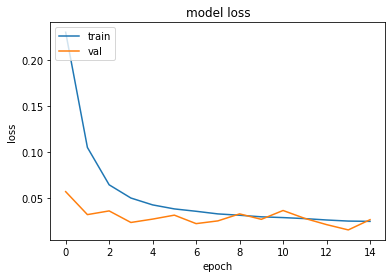

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
### When diffrentiated:
#prediction = predict(model,X_test[:1],test[300]).squeeze()
#actual = postprocess(test[300],y_test[:1]).squeeze()

In [ ]:
import math
from sklearn.metrics import mean_squared_error
#predictions = predict(model,X_val[:1],val[100])
predictions = model.predict(X_test[:1])

#real = postprocess(val[100],y_val[:1])
real = y_test[:1]
real = real.squeeze()
predictions = predictions.squeeze()
print(math.sqrt(mean_squared_error(real,predictions)))

1/1 [==============================] - 0s 16ms/step
0.0963646713126332


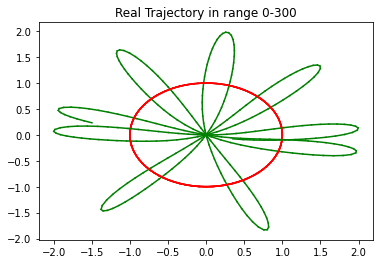

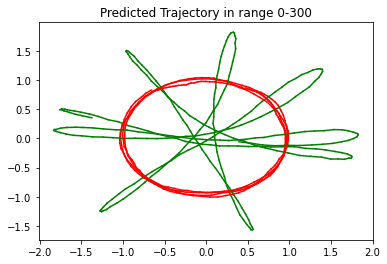

In [ ]:
#real = pendulumSim[len(X_train)+ windowSizeX: len(X_train) + windowSizeX + windowSizeY ]
#simulated = actualPredictions
draw_real_vs_prediction(real, predictions,0,300)

## Three body Flow Example

### Select initial values

In [ ]:
#Body(position,velocity,mass,name)
#%%timeit
bodies=[]
bodies.append(Body([-0.97000436, 0.24308753],[0.466203685, 0.47236573],1,"body1"))
bodies.append(Body([0.91000436, -0.24308753],[0.166203685, 0.43236573],1,"body2"))
bodies.append(Body([0, 0],[-0.93240737, -0.86473146],1,"body3"))

##########################################

# The 8 Figure motion initials

#bodies.append(Body([-0.97000436, 0.24308753],[0.4662036850, 0.4323657300],1,"body1"))
#bodies.append(Body([0.97000436, -0.24308753],[0.4662036850, 0.4323657300],1,"body2"))
#bodies.append(Body([0, 0],[-0.93240737, -0.86473146],1,"body3"))

##########################################

numOfBodies=len(bodies)
##t: timestep . steps: number of steps. interval_in_data
timestep = 0.001 # actual seconds
steps = 222000
#steps = 3000000
interval_in_data = 500

### Create Simulation

In [ ]:
# create simulation
simulation1 = simulate_on_time_step(bodies,timestep,steps,interval_in_data)
#simulation1=simulation1.reshape(len(simulation1), numOfBodies*2 )

### Display Simulation

<class 'numpy.ndarray'>
[[-9.70004360e-01  2.43087530e-01  9.10004360e-01 -2.43087530e-01
   0.00000000e+00  0.00000000e+00]
 [-5.67994235e-01  3.71005109e-01  8.47772680e-01 -9.94150343e-03
  -4.89778445e-01 -3.41063605e-01]
 [ 1.67894996e-02  9.35620525e-02  4.98402654e-01  2.25162564e-01
  -8.75192153e-01 -2.78724616e-01]
 ...
 [-2.20561135e+01  2.95185394e+00 -2.20666774e+01  2.92204699e+00
  -2.20872091e+01  2.94609906e+00]
 [-2.21030542e+01  2.93987029e+00 -2.21343587e+01  2.93538939e+00
  -2.21225870e+01  2.96474033e+00]
 [-2.21681294e+01  2.93517153e+00 -2.21866639e+01  2.96079429e+00
  -2.21552067e+01  2.96403418e+00]]


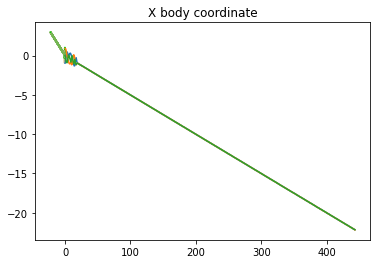

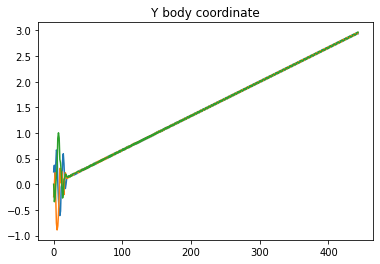

In [ ]:
create_tmp_folder()
drawSimulation(simulation1,'3bodyExample')
showBodiesMovmentInGraph(numpyToPandas(simulation1,numOfBodies))

### Save Simulation

In [ ]:
saveSimulation(simulation1,numOfBodies,f"{numOfBodies}-Body Simulation")

### Build a CNN Model

In [ ]:
model = buildModelCNN(100,100, 4)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 100, 8, 32)        320       
                                                                 
 conv2d_11 (Conv2D)          (None, 100, 8, 32)        25632     
                                                                 
 flatten_2 (Flatten)         (None, 25600)             0         
                                                                 
 dense_2 (Dense)             (None, 800)               20480800  
                                                                 
 reshape_2 (Reshape)         (None, 100, 8)            0         
                                                                 
Total params: 20,506,752
Trainable params: 20,506,752
Non-trainable params: 0
_________________________________________________________________


### Train Model On The Simulation

In [ ]:
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.signal import hilbert
scaled = False 

batch = 128

diffSimulation1 = np.diff(simulation1,axis = 0)
#diffSimulation1 = preprocessSimulation(simulation1)
#diffSimulation1 = np.diff(simulation1[:,2:8],axis = 0)
train, val, test = splitToTrainValidTest(diffSimulation1,0.05)


windowSizeX=100#len(test)
windowSizeY =100#len(test)


if scaled:
  scaler = StandardScaler()
  scaler.fit(simulation1[:len(train)+len(val)])
  #valScaler.fit(train)  ### train / val as input ? 

  train = scaler.transform(train)
  val = scaler.transform(val)
  #train = hilbert(train)
  #val = hilbert(val)

X_train, y_train = prepareData(train,windowSizeX,windowSizeY)
X_val, y_val = prepareData(val,windowSizeX,windowSizeY)
X_test, y_test = prepareData(test,windowSizeX,windowSizeY)

#model =  buildModelCNN(windowSizeX,windowSizeY,numOfBodies)
model = Inceptionmodel(windowSizeX,windowSizeY, numOfBodies)
cp1 = ModelCheckpoint('Inceptionmodel/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
#Inceptionmodel.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])



#generator = TimeseriesGenerator(train_scaled,train_scaled,length = len(test),batch_size=batch)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 6, 1)]  0           []                               
                                                                                                  
 conv2d_12 (Conv2D)             (None, 98, 4, 64)    640         ['input_2[0][0]']                
                                                                                                  
 conv2d_14 (Conv2D)             (None, 98, 4, 32)    320         ['input_2[0][0]']                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 98, 4, 128)   73856       ['conv2d_12[0][0]']              
                                                                                            

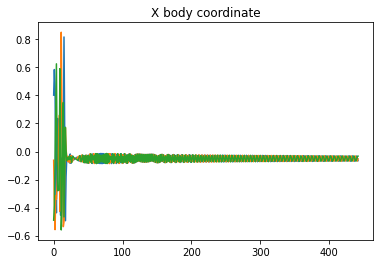

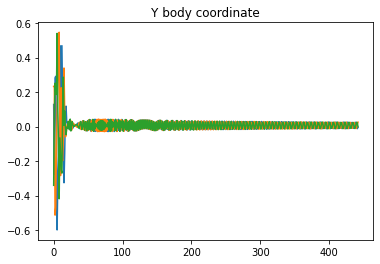

In [ ]:
showBodiesMovmentInGraph(numpyToPandas(diffSimulation1,numOfBodies))

### Train Model On Simulation

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[cp1])

Epoch 1/100
5/7 [====================>.........] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0335

7/7 [==============================] - 1s 20ms/step - loss: 0.0011 - root_mean_squared_error: 0.0330
Epoch 2/100
5/7 [====================>.........] - ETA: 0s - loss: 5.2492e-04 - root_mean_squared_error: 0.0229

7/7 [==============================] - 0s 16ms/step - loss: 5.0562e-04 - root_mean_squared_error: 0.0225
Epoch 3/100
6/7 [========================>.....] - ETA: 0s - loss: 3.7213e-04 - root_mean_squared_error: 0.0193

7/7 [==============================] - 0s 14ms/step - loss: 3.7137e-04 - root_mean_squared_error: 0.0193
Epoch 4/100
6/7 [========================>.....] - ETA: 0s - loss: 3.5635e-04 - root_mean_squared_error: 0.0189

7/7 [==============================] - 0s 14ms/step - loss: 3.5448e-04 - root_mean_squared_error: 0.0188
Epoch 5/100
7/7 [==============================] - ETA: 0s - loss: 3.3287e-04 - root_mean_squared_error: 0.0182

7/7 [==============================] - 0s 13ms/step - loss: 3.3287e-04 - root_mean_squared_error: 0.0182
Epoch 6/100
6/7 [========================>.....] - ETA: 0s - loss: 3.2726e-04 - root_mean_squared_error: 0.0181

7/7 [==============================] - 0s 13ms/step - loss: 3.2668e-04 - root_mean_squared_error: 0.0181
Epoch 7/100
7/7 [==============================] - ETA: 0s - loss: 3.2264e-04 - root_mean_squared_error: 0.0180

7/7 [==============================] - 0s 12ms/step - loss: 3.2264e-04 - root_mean_squared_error: 0.0180
Epoch 8/100
6/7 [========================>.....] - ETA: 0s - loss: 3.2192e-04 - root_mean_squared_error: 0.0179

7/7 [==============================] - 0s 12ms/step - loss: 3.2255e-04 - root_mean_squared_error: 0.0180
Epoch 9/100
6/7 [========================>.....] - ETA: 0s - loss: 3.2066e-04 - root_mean_squared_error: 0.0179

7/7 [==============================] - 0s 13ms/step - loss: 3.2053e-04 - root_mean_squared_error: 0.0179
Epoch 10/100
7/7 [==============================] - ETA: 0s - loss: 3.2051e-04 - root_mean_squared_error: 0.0179

7/7 [==============================] - 0s 12ms/step - loss: 3.2051e-04 - root_mean_squared_error: 0.0179
Epoch 11/100
6/7 [========================>.....] - ETA: 0s - loss: 3.1847e-04 - root_mean_squared_error: 0.0178

7/7 [==============================] - 0s 13ms/step - loss: 3.1983e-04 - root_mean_squared_error: 0.0179
Epoch 12/100
7/7 [==============================] - ETA: 0s - loss: 3.1891e-04 - root_mean_squared_error: 0.0179

7/7 [==============================] - 0s 13ms/step - loss: 3.1891e-04 - root_mean_squared_error: 0.0179
Epoch 13/100
7/7 [==============================] - ETA: 0s - loss: 3.1903e-04 - root_mean_squared_error: 0.0179

7/7 [==============================] - 0s 11ms/step - loss: 3.1903e-04 - root_mean_squared_error: 0.0179
Epoch 14/100
7/7 [==============================] - ETA: 0s - loss: 3.1841e-04 - root_mean_squared_error: 0.0178

7/7 [==============================] - 0s 11ms/step - loss: 3.1841e-04 - root_mean_squared_error: 0.0178
Epoch 15/100
7/7 [==============================] - ETA: 0s - loss: 3.1537e-04 - root_mean_squared_error: 0.0178

7/7 [==============================] - 0s 12ms/step - loss: 3.1537e-04 - root_mean_squared_error: 0.0178
Epoch 16/100
7/7 [==============================] - ETA: 0s - loss: 3.0936e-04 - root_mean_squared_error: 0.0176

7/7 [==============================] - 0s 12ms/step - loss: 3.0936e-04 - root_mean_squared_error: 0.0176
Epoch 17/100
7/7 [==============================] - ETA: 0s - loss: 3.0547e-04 - root_mean_squared_error: 0.0175

7/7 [==============================] - 0s 12ms/step - loss: 3.0547e-04 - root_mean_squared_error: 0.0175
Epoch 18/100
7/7 [==============================] - ETA: 0s - loss: 3.0013e-04 - root_mean_squared_error: 0.0173

7/7 [==============================] - 0s 12ms/step - loss: 3.0013e-04 - root_mean_squared_error: 0.0173
Epoch 19/100
7/7 [==============================] - ETA: 0s - loss: 2.9676e-04 - root_mean_squared_error: 0.0172

7/7 [==============================] - 0s 11ms/step - loss: 2.9676e-04 - root_mean_squared_error: 0.0172
Epoch 20/100
7/7 [==============================] - ETA: 0s - loss: 2.9624e-04 - root_mean_squared_error: 0.0172

7/7 [==============================] - 0s 12ms/step - loss: 2.9624e-04 - root_mean_squared_error: 0.0172
Epoch 21/100
7/7 [==============================] - ETA: 0s - loss: 2.9308e-04 - root_mean_squared_error: 0.0171

7/7 [==============================] - 0s 12ms/step - loss: 2.9308e-04 - root_mean_squared_error: 0.0171
Epoch 22/100
6/7 [========================>.....] - ETA: 0s - loss: 2.9174e-04 - root_mean_squared_error: 0.0171

7/7 [==============================] - 0s 13ms/step - loss: 2.9254e-04 - root_mean_squared_error: 0.0171
Epoch 23/100
7/7 [==============================] - ETA: 0s - loss: 2.9040e-04 - root_mean_squared_error: 0.0170

7/7 [==============================] - 0s 12ms/step - loss: 2.9040e-04 - root_mean_squared_error: 0.0170
Epoch 24/100
7/7 [==============================] - ETA: 0s - loss: 2.8908e-04 - root_mean_squared_error: 0.0170

7/7 [==============================] - 0s 12ms/step - loss: 2.8908e-04 - root_mean_squared_error: 0.0170
Epoch 25/100
7/7 [==============================] - ETA: 0s - loss: 2.9012e-04 - root_mean_squared_error: 0.0170

7/7 [==============================] - 0s 12ms/step - loss: 2.9012e-04 - root_mean_squared_error: 0.0170
Epoch 26/100
7/7 [==============================] - ETA: 0s - loss: 2.8781e-04 - root_mean_squared_error: 0.0170

7/7 [==============================] - 0s 12ms/step - loss: 2.8781e-04 - root_mean_squared_error: 0.0170
Epoch 27/100
7/7 [==============================] - ETA: 0s - loss: 2.8780e-04 - root_mean_squared_error: 0.0170

7/7 [==============================] - 0s 14ms/step - loss: 2.8780e-04 - root_mean_squared_error: 0.0170
Epoch 28/100
5/7 [====================>.........] - ETA: 0s - loss: 2.8381e-04 - root_mean_squared_error: 0.0168

7/7 [==============================] - 0s 18ms/step - loss: 2.8741e-04 - root_mean_squared_error: 0.0170
Epoch 29/100
4/7 [================>.............] - ETA: 0s - loss: 2.9679e-04 - root_mean_squared_error: 0.0172

7/7 [==============================] - 0s 23ms/step - loss: 2.8635e-04 - root_mean_squared_error: 0.0169
Epoch 30/100
5/7 [====================>.........] - ETA: 0s - loss: 2.8464e-04 - root_mean_squared_error: 0.0169

7/7 [==============================] - 0s 21ms/step - loss: 2.8625e-04 - root_mean_squared_error: 0.0169
Epoch 31/100
5/7 [====================>.........] - ETA: 0s - loss: 2.8564e-04 - root_mean_squared_error: 0.0169

7/7 [==============================] - 0s 21ms/step - loss: 2.8600e-04 - root_mean_squared_error: 0.0169
Epoch 32/100
5/7 [====================>.........] - ETA: 0s - loss: 2.8290e-04 - root_mean_squared_error: 0.0168

7/7 [==============================] - 0s 27ms/step - loss: 2.8450e-04 - root_mean_squared_error: 0.0169
Epoch 33/100
5/7 [====================>.........] - ETA: 0s - loss: 2.8745e-04 - root_mean_squared_error: 0.0170

7/7 [==============================] - 0s 28ms/step - loss: 2.8605e-04 - root_mean_squared_error: 0.0169
Epoch 34/100
4/7 [================>.............] - ETA: 0s - loss: 2.8059e-04 - root_mean_squared_error: 0.0168

7/7 [==============================] - 0s 23ms/step - loss: 2.8459e-04 - root_mean_squared_error: 0.0169
Epoch 35/100
5/7 [====================>.........] - ETA: 0s - loss: 2.9088e-04 - root_mean_squared_error: 0.0171

7/7 [==============================] - 0s 24ms/step - loss: 2.8249e-04 - root_mean_squared_error: 0.0168
Epoch 36/100
4/7 [================>.............] - ETA: 0s - loss: 2.8349e-04 - root_mean_squared_error: 0.0168

7/7 [==============================] - 0s 26ms/step - loss: 2.8187e-04 - root_mean_squared_error: 0.0168
Epoch 37/100
6/7 [========================>.....] - ETA: 0s - loss: 2.7834e-04 - root_mean_squared_error: 0.0167

7/7 [==============================] - 0s 21ms/step - loss: 2.8014e-04 - root_mean_squared_error: 0.0167
Epoch 38/100
7/7 [==============================] - ETA: 0s - loss: 2.7800e-04 - root_mean_squared_error: 0.0167

7/7 [==============================] - 0s 30ms/step - loss: 2.7800e-04 - root_mean_squared_error: 0.0167
Epoch 39/100
5/7 [====================>.........] - ETA: 0s - loss: 2.7569e-04 - root_mean_squared_error: 0.0166

7/7 [==============================] - 0s 20ms/step - loss: 2.7534e-04 - root_mean_squared_error: 0.0166
Epoch 40/100
4/7 [================>.............] - ETA: 0s - loss: 2.7730e-04 - root_mean_squared_error: 0.0167

7/7 [==============================] - 0s 21ms/step - loss: 2.7320e-04 - root_mean_squared_error: 0.0165
Epoch 41/100
5/7 [====================>.........] - ETA: 0s - loss: 2.6304e-04 - root_mean_squared_error: 0.0162

7/7 [==============================] - 0s 27ms/step - loss: 2.6473e-04 - root_mean_squared_error: 0.0163
Epoch 42/100
7/7 [==============================] - ETA: 0s - loss: 2.5432e-04 - root_mean_squared_error: 0.0159

7/7 [==============================] - 0s 25ms/step - loss: 2.5432e-04 - root_mean_squared_error: 0.0159
Epoch 43/100
6/7 [========================>.....] - ETA: 0s - loss: 2.3750e-04 - root_mean_squared_error: 0.0154

7/7 [==============================] - 0s 27ms/step - loss: 2.3734e-04 - root_mean_squared_error: 0.0154
Epoch 44/100
5/7 [====================>.........] - ETA: 0s - loss: 2.1665e-04 - root_mean_squared_error: 0.0147

7/7 [==============================] - 0s 20ms/step - loss: 2.1675e-04 - root_mean_squared_error: 0.0147
Epoch 45/100
4/7 [================>.............] - ETA: 0s - loss: 1.8795e-04 - root_mean_squared_error: 0.0137

7/7 [==============================] - 0s 23ms/step - loss: 1.8869e-04 - root_mean_squared_error: 0.0137
Epoch 46/100
6/7 [========================>.....] - ETA: 0s - loss: 1.7220e-04 - root_mean_squared_error: 0.0131

7/7 [==============================] - 0s 25ms/step - loss: 1.7266e-04 - root_mean_squared_error: 0.0131
Epoch 47/100
5/7 [====================>.........] - ETA: 0s - loss: 1.6295e-04 - root_mean_squared_error: 0.0128

7/7 [==============================] - 0s 17ms/step - loss: 1.5745e-04 - root_mean_squared_error: 0.0125
Epoch 48/100
5/7 [====================>.........] - ETA: 0s - loss: 1.5196e-04 - root_mean_squared_error: 0.0123

7/7 [==============================] - 0s 19ms/step - loss: 1.4743e-04 - root_mean_squared_error: 0.0121
Epoch 49/100
5/7 [====================>.........] - ETA: 0s - loss: 1.4084e-04 - root_mean_squared_error: 0.0119

7/7 [==============================] - 0s 19ms/step - loss: 1.3959e-04 - root_mean_squared_error: 0.0118
Epoch 50/100
5/7 [====================>.........] - ETA: 0s - loss: 1.2793e-04 - root_mean_squared_error: 0.0113

7/7 [==============================] - 0s 16ms/step - loss: 1.3232e-04 - root_mean_squared_error: 0.0115
Epoch 51/100
5/7 [====================>.........] - ETA: 0s - loss: 1.2864e-04 - root_mean_squared_error: 0.0113

7/7 [==============================] - 0s 16ms/step - loss: 1.2908e-04 - root_mean_squared_error: 0.0114
Epoch 52/100
6/7 [========================>.....] - ETA: 0s - loss: 1.2402e-04 - root_mean_squared_error: 0.0111

7/7 [==============================] - 0s 22ms/step - loss: 1.2471e-04 - root_mean_squared_error: 0.0112
Epoch 53/100
5/7 [====================>.........] - ETA: 0s - loss: 1.2560e-04 - root_mean_squared_error: 0.0112

7/7 [==============================] - 0s 18ms/step - loss: 1.2151e-04 - root_mean_squared_error: 0.0110
Epoch 54/100
6/7 [========================>.....] - ETA: 0s - loss: 1.2039e-04 - root_mean_squared_error: 0.0110

7/7 [==============================] - 0s 14ms/step - loss: 1.1925e-04 - root_mean_squared_error: 0.0109
Epoch 55/100
5/7 [====================>.........] - ETA: 0s - loss: 1.1548e-04 - root_mean_squared_error: 0.0107

7/7 [==============================] - 0s 26ms/step - loss: 1.1505e-04 - root_mean_squared_error: 0.0107
Epoch 56/100
4/7 [================>.............] - ETA: 0s - loss: 1.0842e-04 - root_mean_squared_error: 0.0104

7/7 [==============================] - 0s 23ms/step - loss: 1.0933e-04 - root_mean_squared_error: 0.0105
Epoch 57/100
5/7 [====================>.........] - ETA: 0s - loss: 9.9779e-05 - root_mean_squared_error: 0.0100

7/7 [==============================] - 0s 20ms/step - loss: 1.0704e-04 - root_mean_squared_error: 0.0103
Epoch 58/100
6/7 [========================>.....] - ETA: 0s - loss: 1.0362e-04 - root_mean_squared_error: 0.0102

7/7 [==============================] - 0s 13ms/step - loss: 1.0227e-04 - root_mean_squared_error: 0.0101
Epoch 59/100
7/7 [==============================] - ETA: 0s - loss: 9.4109e-05 - root_mean_squared_error: 0.0097

7/7 [==============================] - 0s 12ms/step - loss: 9.4109e-05 - root_mean_squared_error: 0.0097
Epoch 60/100
6/7 [========================>.....] - ETA: 0s - loss: 8.5658e-05 - root_mean_squared_error: 0.0093

7/7 [==============================] - 0s 13ms/step - loss: 8.5324e-05 - root_mean_squared_error: 0.0092
Epoch 61/100
7/7 [==============================] - ETA: 0s - loss: 7.5449e-05 - root_mean_squared_error: 0.0087

7/7 [==============================] - 0s 12ms/step - loss: 7.5449e-05 - root_mean_squared_error: 0.0087
Epoch 62/100
7/7 [==============================] - ETA: 0s - loss: 6.3410e-05 - root_mean_squared_error: 0.0080

7/7 [==============================] - 0s 12ms/step - loss: 6.3410e-05 - root_mean_squared_error: 0.0080
Epoch 63/100
7/7 [==============================] - ETA: 0s - loss: 4.8191e-05 - root_mean_squared_error: 0.0069

7/7 [==============================] - 0s 12ms/step - loss: 4.8191e-05 - root_mean_squared_error: 0.0069
Epoch 64/100
6/7 [========================>.....] - ETA: 0s - loss: 3.7325e-05 - root_mean_squared_error: 0.0061

7/7 [==============================] - 0s 13ms/step - loss: 3.6995e-05 - root_mean_squared_error: 0.0061
Epoch 65/100
7/7 [==============================] - ETA: 0s - loss: 2.6208e-05 - root_mean_squared_error: 0.0051

7/7 [==============================] - 0s 12ms/step - loss: 2.6208e-05 - root_mean_squared_error: 0.0051
Epoch 66/100
7/7 [==============================] - ETA: 0s - loss: 1.9633e-05 - root_mean_squared_error: 0.0044

7/7 [==============================] - 0s 12ms/step - loss: 1.9633e-05 - root_mean_squared_error: 0.0044
Epoch 67/100
7/7 [==============================] - ETA: 0s - loss: 1.6424e-05 - root_mean_squared_error: 0.0041

7/7 [==============================] - 0s 12ms/step - loss: 1.6424e-05 - root_mean_squared_error: 0.0041
Epoch 68/100
7/7 [==============================] - ETA: 0s - loss: 1.2653e-05 - root_mean_squared_error: 0.0036

7/7 [==============================] - 0s 11ms/step - loss: 1.2653e-05 - root_mean_squared_error: 0.0036
Epoch 69/100
7/7 [==============================] - ETA: 0s - loss: 1.1191e-05 - root_mean_squared_error: 0.0033

7/7 [==============================] - 0s 12ms/step - loss: 1.1191e-05 - root_mean_squared_error: 0.0033
Epoch 70/100
7/7 [==============================] - ETA: 0s - loss: 9.5195e-06 - root_mean_squared_error: 0.0031

7/7 [==============================] - 0s 12ms/step - loss: 9.5195e-06 - root_mean_squared_error: 0.0031
Epoch 71/100
6/7 [========================>.....] - ETA: 0s - loss: 8.0732e-06 - root_mean_squared_error: 0.0028

7/7 [==============================] - 0s 13ms/step - loss: 8.1529e-06 - root_mean_squared_error: 0.0029
Epoch 72/100
7/7 [==============================] - ETA: 0s - loss: 7.2472e-06 - root_mean_squared_error: 0.0027

7/7 [==============================] - 0s 12ms/step - loss: 7.2472e-06 - root_mean_squared_error: 0.0027
Epoch 73/100
7/7 [==============================] - ETA: 0s - loss: 6.4827e-06 - root_mean_squared_error: 0.0025

7/7 [==============================] - 0s 13ms/step - loss: 6.4827e-06 - root_mean_squared_error: 0.0025
Epoch 74/100
7/7 [==============================] - ETA: 0s - loss: 5.7711e-06 - root_mean_squared_error: 0.0024

7/7 [==============================] - 0s 12ms/step - loss: 5.7711e-06 - root_mean_squared_error: 0.0024
Epoch 75/100
7/7 [==============================] - ETA: 0s - loss: 5.0374e-06 - root_mean_squared_error: 0.0022

7/7 [==============================] - 0s 11ms/step - loss: 5.0374e-06 - root_mean_squared_error: 0.0022
Epoch 76/100
7/7 [==============================] - ETA: 0s - loss: 4.5474e-06 - root_mean_squared_error: 0.0021

7/7 [==============================] - 0s 14ms/step - loss: 4.5474e-06 - root_mean_squared_error: 0.0021
Epoch 77/100
7/7 [==============================] - ETA: 0s - loss: 4.0309e-06 - root_mean_squared_error: 0.0020

7/7 [==============================] - 0s 12ms/step - loss: 4.0309e-06 - root_mean_squared_error: 0.0020
Epoch 78/100
7/7 [==============================] - ETA: 0s - loss: 3.7201e-06 - root_mean_squared_error: 0.0019

7/7 [==============================] - 0s 12ms/step - loss: 3.7201e-06 - root_mean_squared_error: 0.0019
Epoch 79/100
7/7 [==============================] - ETA: 0s - loss: 3.4870e-06 - root_mean_squared_error: 0.0019

7/7 [==============================] - 0s 12ms/step - loss: 3.4870e-06 - root_mean_squared_error: 0.0019
Epoch 80/100
7/7 [==============================] - ETA: 0s - loss: 3.3099e-06 - root_mean_squared_error: 0.0018

7/7 [==============================] - 0s 12ms/step - loss: 3.3099e-06 - root_mean_squared_error: 0.0018
Epoch 81/100
7/7 [==============================] - ETA: 0s - loss: 3.0609e-06 - root_mean_squared_error: 0.0017

7/7 [==============================] - 0s 12ms/step - loss: 3.0609e-06 - root_mean_squared_error: 0.0017
Epoch 82/100
7/7 [==============================] - ETA: 0s - loss: 2.8043e-06 - root_mean_squared_error: 0.0017

7/7 [==============================] - 0s 12ms/step - loss: 2.8043e-06 - root_mean_squared_error: 0.0017
Epoch 83/100
6/7 [========================>.....] - ETA: 0s - loss: 2.8871e-06 - root_mean_squared_error: 0.0017

7/7 [==============================] - 0s 13ms/step - loss: 2.8615e-06 - root_mean_squared_error: 0.0017
Epoch 84/100
7/7 [==============================] - ETA: 0s - loss: 2.6507e-06 - root_mean_squared_error: 0.0016

7/7 [==============================] - 0s 12ms/step - loss: 2.6507e-06 - root_mean_squared_error: 0.0016
Epoch 85/100
7/7 [==============================] - ETA: 0s - loss: 2.4105e-06 - root_mean_squared_error: 0.0016

7/7 [==============================] - 0s 12ms/step - loss: 2.4105e-06 - root_mean_squared_error: 0.0016
Epoch 86/100
7/7 [==============================] - ETA: 0s - loss: 2.4640e-06 - root_mean_squared_error: 0.0016

7/7 [==============================] - 0s 12ms/step - loss: 2.4640e-06 - root_mean_squared_error: 0.0016
Epoch 87/100
6/7 [========================>.....] - ETA: 0s - loss: 2.3238e-06 - root_mean_squared_error: 0.0015

7/7 [==============================] - 0s 13ms/step - loss: 2.2965e-06 - root_mean_squared_error: 0.0015
Epoch 88/100
6/7 [========================>.....] - ETA: 0s - loss: 2.2389e-06 - root_mean_squared_error: 0.0015

7/7 [==============================] - 0s 15ms/step - loss: 2.1983e-06 - root_mean_squared_error: 0.0015
Epoch 89/100
7/7 [==============================] - ETA: 0s - loss: 2.0150e-06 - root_mean_squared_error: 0.0014

7/7 [==============================] - 0s 13ms/step - loss: 2.0150e-06 - root_mean_squared_error: 0.0014
Epoch 90/100
7/7 [==============================] - ETA: 0s - loss: 1.9313e-06 - root_mean_squared_error: 0.0014

7/7 [==============================] - 0s 11ms/step - loss: 1.9313e-06 - root_mean_squared_error: 0.0014
Epoch 91/100
7/7 [==============================] - ETA: 0s - loss: 1.7991e-06 - root_mean_squared_error: 0.0013

7/7 [==============================] - 0s 12ms/step - loss: 1.7991e-06 - root_mean_squared_error: 0.0013
Epoch 92/100
7/7 [==============================] - ETA: 0s - loss: 1.6798e-06 - root_mean_squared_error: 0.0013

7/7 [==============================] - 0s 12ms/step - loss: 1.6798e-06 - root_mean_squared_error: 0.0013
Epoch 93/100
7/7 [==============================] - ETA: 0s - loss: 1.9015e-06 - root_mean_squared_error: 0.0014

7/7 [==============================] - 0s 12ms/step - loss: 1.9015e-06 - root_mean_squared_error: 0.0014
Epoch 94/100
7/7 [==============================] - ETA: 0s - loss: 1.6529e-06 - root_mean_squared_error: 0.0013

7/7 [==============================] - 0s 12ms/step - loss: 1.6529e-06 - root_mean_squared_error: 0.0013
Epoch 95/100
7/7 [==============================] - ETA: 0s - loss: 1.9004e-06 - root_mean_squared_error: 0.0014

7/7 [==============================] - 0s 12ms/step - loss: 1.9004e-06 - root_mean_squared_error: 0.0014
Epoch 96/100
7/7 [==============================] - ETA: 0s - loss: 1.8011e-06 - root_mean_squared_error: 0.0013

7/7 [==============================] - 0s 12ms/step - loss: 1.8011e-06 - root_mean_squared_error: 0.0013
Epoch 97/100
7/7 [==============================] - ETA: 0s - loss: 1.6027e-06 - root_mean_squared_error: 0.0013

7/7 [==============================] - 0s 12ms/step - loss: 1.6027e-06 - root_mean_squared_error: 0.0013
Epoch 98/100
7/7 [==============================] - ETA: 0s - loss: 1.5391e-06 - root_mean_squared_error: 0.0012

7/7 [==============================] - 0s 12ms/step - loss: 1.5391e-06 - root_mean_squared_error: 0.0012
Epoch 99/100
7/7 [==============================] - ETA: 0s - loss: 1.4104e-06 - root_mean_squared_error: 0.0012

7/7 [==============================] - 0s 12ms/step - loss: 1.4104e-06 - root_mean_squared_error: 0.0012
Epoch 100/100
6/7 [========================>.....] - ETA: 0s - loss: 1.4328e-06 - root_mean_squared_error: 0.0012

7/7 [==============================] - 0s 12ms/step - loss: 1.4106e-06 - root_mean_squared_error: 0.0012


### Display Model Loss Function

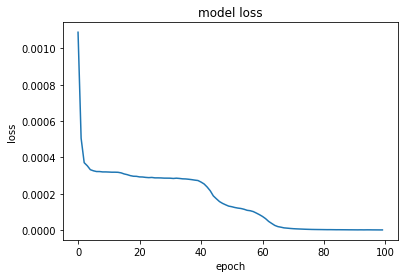

In [ ]:
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Display Model Prediction

In [ ]:
from sklearn.metrics import mean_squared_error
predictions = model.predict(X_train[-1:])
predictions=predictions.squeeze()

# One-shot prediction : 
actualPredictions = postprocess(simulation1[len(X_train)+windowSizeX-1],predictions)
##### ACTUAL RMSE #####
print(math.sqrt(mean_squared_error(postprocess(simulation1[len(X_train)-1],diffSimulation1[len(X_train):len(X_train)+windowSizeY]),actualPredictions)))

1/1 [==============================] - 0s 95ms/step
3.552648226382116


### Autoregressive prediction

In [ ]:
#######  Autoregressive prediction - Only in case Y window is in size 1 ######
import math

if windowSizeY == 1:

    AutoregressivePredictions = slidingWindowActualPredictions(model,X_train,windowSizeX,numOfBodies,len(test))
    AutoregressivePredictions =np.array(AutoregressivePredictions)
    AutoregressivePredictions = AutoregressivePredictions.squeeze()

    actualPredictions = postprocess(simulation1[len(X_train)+len(test)-1],AutoregressivePredictions)

    if scaled:
      actualPredictions = scaler.inverse_transform(actualPredictions)
  ##### ACTUAL RMSE #####
    print(math.sqrt(mean_squared_error(postprocess(simulation1[len(X_train)-1],diffSimulation1[len(X_train):len(X_train)+windowSizeY]),actualPredictions)))

### Display the difference between the prediction and the simulation

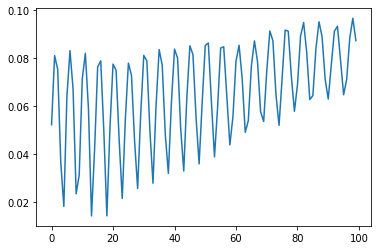

In [ ]:
### Distance at each point throught the prediction
import matplotlib.pyplot as plt
disArr = []
#for i in range(len(val)+len(test)):
  #disArr.append(np.linalg.norm(simulation1[len(X_train)+windowSizeX+i+1]-listOfPredictionsTrue[i]))
for i in range(windowSizeY):
  disArr.append(np.linalg.norm(postprocess(simulation1[len(X_train)+windowSizeX-1],diffSimulation1[len(X_train)+windowSizeX:len(X_train)+windowSizeX+windowSizeY])[i]-actualPredictions[i]))

plt.plot(disArr)

### Display Prediction and Simulation side by side

<class 'numpy.ndarray'>
[[-14.9678744    2.01146729 -14.95535834   1.98242553 -14.98676726
    1.98610718]
 [-15.00187042   2.00216259 -15.02719193   1.98321803 -15.03093765
    2.01461938]
 [-15.06362786   1.98955661 -15.08800382   2.00970326 -15.05836833
    2.02074013]
 [-15.13510348   2.00307453 -15.12133264   2.03154273 -15.10356388
    2.00538273]
 [-15.18358537   2.03219819 -15.15264337   2.02566618 -15.17377125
    2.00213563]
 [-15.21145859   2.04280365 -15.21029566   2.0112011  -15.23824574
    2.02599525]
 [-15.25226375   2.02899936 -15.28262145   2.02014027 -15.2751148
    2.05086036]
 [-15.31982091   2.02174279 -15.33590076   2.04897351 -15.30427834
    2.04928371]
 [-15.387637     2.04194501 -15.36527058   2.06430158 -15.35709243
    2.03375341]
 [-15.42900288   2.06921747 -15.40174249   2.05318798 -15.42925463
    2.03759454]
 [-15.45691743   2.07273593 -15.46551164   2.0423022  -15.48757093
    2.06496187]
 [-15.50434198   2.05727604 -15.53596153   2.05780174 -15.519696

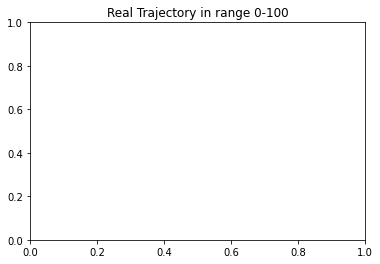

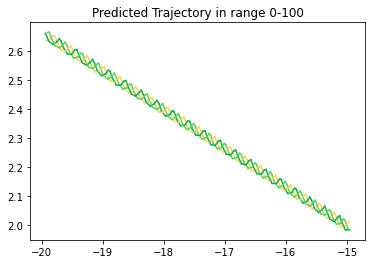

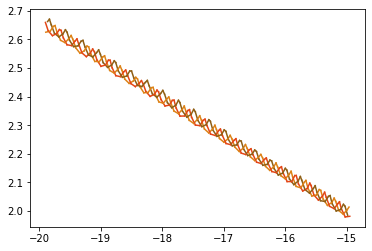

In [ ]:
real = simulation1[len(X_train)+ windowSizeX: len(X_train) + windowSizeX + windowSizeY ]
simulated = actualPredictions
draw_real_vs_prediction(real, simulated,f"{numOfBodies}-Body Simulation")

## Double Pendulum Flow Example

In [ ]:
pendulum = double_pendulum(angle=[120,-10])
pendulumSimTest = simulate_double_pendulum(pendulum,0.01,10,250)
drawSimulation(pendulumSimTest,"test_dp3")

In [ ]:
drawSimulation(pendulumSimTest[:250],"double_pendulum_sim_example")

In [ ]:
numOfBodies = 2
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.signal import hilbert
scaled = False 

batch = 128

diffSimulation1 = np.diff(pendulumSimTest,axis = 0)
#diffSimulation1 = preprocessSimulation(simulation1)
#diffSimulation1 = np.diff(simulation1[:,2:8],axis = 0)
train, val, test = splitToTrainValidTest(diffSimulation1,0.05)


windowSizeX=300#len(test)
windowSizeY =300#len(test)


if scaled:
  scaler = StandardScaler()
  scaler.fit(simulation1[:len(train)+len(val)])
  #valScaler.fit(train)  ### train / val as input ? 

  train = scaler.transform(train)
  val = scaler.transform(val)
  #train = hilbert(train)
  #val = hilbert(val)

X_train, y_train = prepareData(train,windowSizeX,windowSizeY)
X_val, y_val = prepareData(val,windowSizeX,windowSizeY)
X_test, y_test = prepareData(test,windowSizeX,windowSizeY)


#generator = TimeseriesGenerator(train_scaled,train_scaled,length = len(test),batch_size=batch)

In [ ]:
model =  Inceptionmodel(windowSizeX,windowSizeY,2)
#model =  buildModelCNN(windowSizeX,windowSizeY,numOfBodies)
#model =  model(windowSizeX,windowSizeY,numOfBodies)
cp1 = ModelCheckpoint('Inceptionmodel/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
#Inceptionmodel.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [ ]:
showBodiesMovmentInGraph(numpyToPandas(diffSimulation1,numOfBodies))

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp1])

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(X_train[-1:])
predictions=predictions.squeeze()

# One-shot prediction : 
actualPredictions = postprocess(pendulumSim[len(X_train)+windowSizeX-1],predictions)
##### ACTUAL RMSE #####
print(math.sqrt(mean_squared_error(postprocess(pendulumSim[len(X_train)-1],diffSimulation1[len(X_train):len(X_train)+windowSizeY]),actualPredictions)))


In [ ]:
real = pendulumSim[len(X_train)+ windowSizeX: len(X_train) + windowSizeX + windowSizeY ]
simulated = actualPredictions
draw_real_vs_prediction(real, simulated,0,windowSizeY)

## Logistic Map test

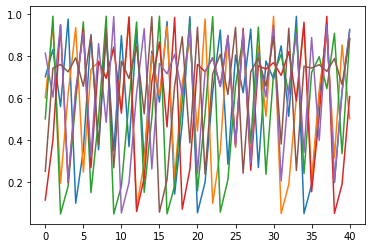

In [ ]:
logmap = []

x = [0.7,0.6,0.5,0.114,0.812,0.25]
x = np.array(x)
r = 3.951
logmap.append(x)
for i in range(40):
  x = x*r*(1-x)
  logmap.append(x)


plt.plot(logmap)
plt.show()  


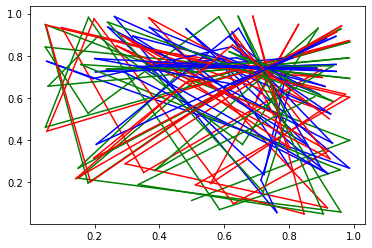

In [ ]:
drawSimulation(logmap)

Install Anvil uplink connection

In [ ]:
!pip install anvil-uplink

Connect Colab with the Anvil project

In [ ]:
import anvil.server
anvil.server.connect("M2SHTQKH2FUIJQQXXX4VKXEB-I37SIP4DTE6Z5NM3") # <----- [insert your anvil uplink here]

In [ ]:
!pip install pandas